In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from PIL import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf

import numpy as np
import cv2
import pprint
import h5py
import os
import PIL

import src.dagm_loader as dagm
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


# Show if tensorflow can run with GPU
# Run tensorflow keras on multiple core

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 340575336881660196
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9031163130365660211
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [3]:
# dagm.create_dataset('./data/DAGM_KaggleUpload/Class6/Train/', 'Train', 96)
# dagm.create_dataset('./data/DAGM_KaggleUpload/Class6/Test/', 'Test', 96)

# Load DAGM data

In [4]:
x_train, y_train = dagm.load_dataset('Train', 'data')
x_test, y_test = dagm.load_dataset('Test', 'data')

In [5]:
x_valid_length = round(len(x_test)/2)

x_valid = np.array(x_test[x_valid_length:])
x_test = np.array(x_test[:x_valid_length])

y_valid = y_test[x_valid_length:]
y_test = y_test[:x_valid_length]

In [6]:
print('Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)

Shape of train (55432, 96, 96, 1) 55432 (55432, 1)
Shape of valid (22308, 96, 96, 1) 22308 (22308, 1)
Shape of test (22308, 96, 96, 1) 22308 (22308, 1)


# Load pcam data

In [ ]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

In [8]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

In [6]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)

   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          262144 non-null  int64 
 1   coord_y             262144 non-null  int64 
 2   coord_x             262144 non-null  int64 
 3   tumor_patch         262144 non-

# Build model

In [7]:
batch_size = 10
epochs = 10
num_classes = 2
shape = x_train[0].shape

## Backpropagation

In [8]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation332.h5'

# Define specific approach
# layers = am.unet_layer(input_layer, 7, 16) 
# layers = am.unet_layer(input_layer, 5, 16) 
# layers = am.unet_layer(input_layer, 3, 16) 

# layers = am.unet_layer(input_layer, 7, 32)
# layers = am.unet_layer(input_layer, 5, 32)
layers = am.unet_layer(input_layer, 3, 32)

# layers = am.unet_layer(input_layer, 7, 64) 
# layers = am.unet_layer(input_layer, 5, 64) 
# layers = am.unet_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Autoencoder

In [34]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder332.h5'

# Define specific approach
# layers = am.encoder_layer(input_layer, 7, 16) 
# layers = am.encoder_layer(input_layer, 5, 16) 
# layers = am.encoder_layer(input_layer, 3, 16) 

# layers = am.encoder_layer(input_layer, 7, 32) 
# layers = am.encoder_layer(input_layer, 5, 32) 
layers = am.encoder_layer(input_layer, 3, 32)

# layers = am.encoder_layer(input_layer, 7, 64) 
# layers = am.encoder_layer(input_layer, 5, 64) 
# layers = am.encoder_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Transfer learning

In [8]:
from keras.applications import MobileNet
from keras import applications
model_name = 'adaptive_transfer.h5'

# Transform data to RGB (DAGM neeeded)
# x_train = np.ndarray(shape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3), dtype= np.uint8) 
# x_valid = np.ndarray(shape=(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 3), dtype= np.uint8) 
# x_test = np.ndarray(shape=(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3), dtype= np.uint8) 

# Use ImageNet as first 'layers'

# Define specific approach
# base_model= applications.VGG16(weights = "imagenet", include_top=False)
base_model= applications.resnet.ResNet152(weights = "imagenet", include_top=False)
layer = base_model.output

# Use Unet architecture as main model
outputs_layer = am.unet_model(layer)

# Output layer
outputs_layer = am.transfer_layer(layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(base_model.input, outputs_layer)
    
    
# Set layer to trainable
for layer in model.layers[:15]:
    layer.trainable=False
for layer in model.layers[15:]:
    layer.trainable=True

## Gabor kernels

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor532.h5'

# Define specific approach
# layers = am.gabor_layer(input_layer, 9, 16) 
# layers = am.gabor_layer(input_layer, 7, 16) 
# layers = am.gabor_layer(input_layer, 5, 16) 

layers = am.gabor_layer(input_layer, 9, 32) 
# layers = am.gabor_layer(input_layer, 7, 32)
# layers = am.gabor_layer(input_layer, 5, 32)

# layers = am.gabor_layer(input_layer, 9, 64) 
# layers = am.gabor_layer(input_layer, 7, 64) 
# layers = am.gabor_layer(input_layer, 5, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
weights, gabor_filters = am.gabor_filter(model)
model.layers[1].set_weights(weights)

In [ ]:
# Show Filters
f = np.asarray(gabor_filters)
import pylab as pl


for i in range(1,32):
    pl.subplot(6,6,i)
    pl.imshow(f[i],cmap="gray")
    pl.savefig('gf.png')
pl.show()

## Own Metrics

In [9]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def my_own_preci(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Compile and train the model

In [ ]:
callbacks = [
    cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
#     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
#     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
]

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=[
                  tensorflow.keras.metrics.Precision(),
                  'accuracy',
                  tensorflow.keras.metrics.Recall(),
                  tensorflow.keras.metrics.TruePositives(),
                  tensorflow.keras.metrics.FalsePositives(),
                  tensorflow.keras.metrics.FalseNegatives()
                      ])

In [11]:
history = model.fit(
    x_train,
    to_categorical(y_train),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    callbacks=callbacks,
    use_multiprocessing=True, 
    workers=8
)

Train on 55432 samples, validate on 22308 samples
Epoch 1/10
55432/55432 [==============================] - 147s 3ms/step - loss: 0.2574 - precision: 0.8382 - accuracy: 0.9030 - recall: 0.8382 - true_positives: 24306.5156 - false_positives: 3418.4087 - false_negatives: 3418.4087 - val_loss: 0.2067 - val_precision: 0.9080 - val_accuracy: 0.9335 - val_recall: 0.9080 - val_true_positives: 60481.5781 - val_false_positives: 6110.2651 - val_false_negatives: 6110.2651
Epoch 2/10
55432/55432 [==============================] - 143s 3ms/step - loss: 0.1464 - precision: 0.9212 - accuracy: 0.9519 - recall: 0.9212 - true_positives: 97234.1016 - false_positives: 8230.8281 - false_negatives: 8230.8281 - val_loss: 0.1728 - val_precision: 0.9298 - val_accuracy: 0.9456 - val_recall: 0.9298 - val_true_positives: 134207.3281 - val_false_positives: 10124.7031 - val_false_negatives: 10124.7031
Epoch 3/10
55432/55432 [==============================] - 145s 3ms/step - loss: 0.1211 - precision: 0.9353 - accura

In [12]:
model.save('eop_' + model_name)

# Evaluate the model

In [13]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
f1_score = f1_score_evaluate(test_eval[2], test_eval[3])

In [14]:
print('Test loss:', test_eval[0],end=' ')
print('Precision:', test_eval[1],end=' ')
print('Accuracy:', test_eval[2],end=' ')
print('Recall:', test_eval[3],end=' ')
print('TruePositives:', test_eval[4],end=' ')
print('FalsePositives:', test_eval[5],end=' ')
print('FalseNegatives:', test_eval[6],end=' ')
print('F1_score', f1_score,end=' ')

Test loss: 0.16638017340512234 Precision: 0.9595574140548706 Accuracy: 0.949211061000824 Recall: 0.9595574140548706 TruePositives: 756693.0 FalsePositives: 31891.4375 FalseNegatives: 31891.4375 F1_score 0.9543561466687017 

### Predict on model ( real evaluate ) 

In [15]:
y_pred = model.predict(x_test, verbose=0, workers=8, use_multiprocessing=True)

In [16]:
print('My precision', my_own_preci(to_categorical(y_test), y_pred))
print('My recall', recall(to_categorical(y_test), y_pred))

My precision tf.Tensor(0.94921106, shape=(), dtype=float32)
My recall tf.Tensor(0.94921106, shape=(), dtype=float32)


### Graf from training

In [17]:
print('Name of model is', model_name)

Name of model is adaptive_backpropagation332.h5


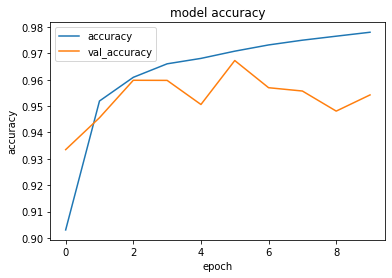

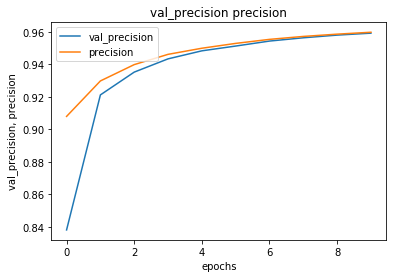

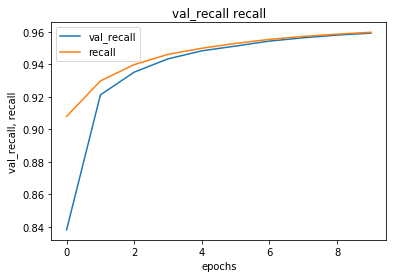

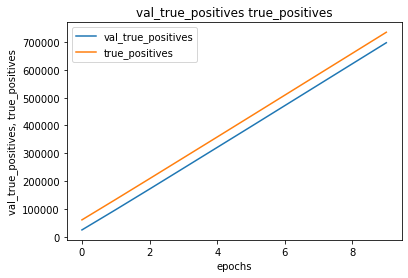

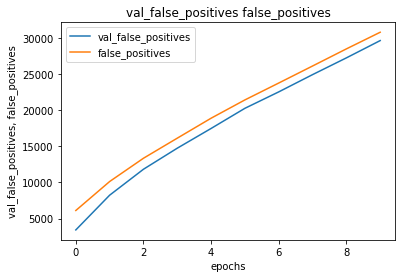

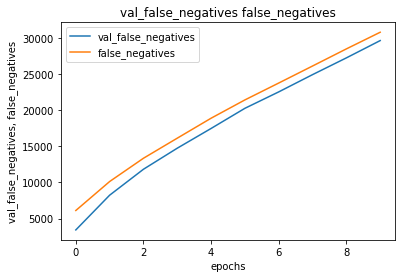

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()


plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('val_precision precision')
plt.ylabel('val_precision, precision')
plt.xlabel('epochs')
plt.legend(['val_precision', 'precision'], loc='upper left')
plt.show()


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('val_recall recall')
plt.ylabel('val_recall, recall')
plt.xlabel('epochs')
plt.legend(['val_recall', 'recall'], loc='upper left')
plt.show()

plt.plot(history.history['true_positives'])
plt.plot(history.history['val_true_positives'])
plt.title('val_true_positives true_positives')
plt.ylabel('val_true_positives, true_positives')
plt.xlabel('epochs')
plt.legend(['val_true_positives', 'true_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_positives'])
plt.plot(history.history['val_false_positives'])
plt.title('val_false_positives false_positives')
plt.ylabel('val_false_positives, false_positives')
plt.xlabel('epochs')
plt.legend(['val_false_positives', 'false_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_negatives'])
plt.plot(history.history['val_false_negatives'])
plt.title('val_false_negatives false_negatives')
plt.ylabel('val_false_negatives, false_negatives')
plt.xlabel('epochs')
plt.legend(['val_false_negatives', 'false_negatives'], loc='upper left')
plt.show()

In [ ]:
true_positives = 0 
true_negatives = 0
test_positives = 0
test_negatives = 0
pred_positives = 0
pred_negatives = 0

for value in to_categorical(y_test):
#     print(value)
    if value[0] == 0:
        test_positives += 1
    else:
        test_negatives += 1
        
for value in K.round(K.clip(y_pred, 0, 1)):
#     print(value)
    if value[0] == 0:
        pred_positives += 1
    else:
        pred_negatives += 1  

test_result = []
predict_result = []
for value in to_categorical(y_test):
#     print(value)
    if value[0] == 0:
        test_result.append(0)
    else:
        test_result.append(1)
        
for value in K.round(K.clip(y_pred, 0, 1)):
#     print(value)
    if value[0] == 0:
        predict_result.append(0)
    else:
        predict_result.append(1)
        
for index, value in enumerate(predict_result):
    if test_result[index] is value:
        if test_result[index] is 0:
            true_positives += 1
        else:
            true_negatives += 1
            


In [31]:
print('true_positives', true_positives)
print('true_negatives', true_negatives)

print('test_positives', test_positives)
print('test_negatives', test_negatives)

print('pred_positives', pred_positives)
print('pred_negatives', pred_negatives)

true_positives 6678
true_negatives 14497
test_positives 7731
test_negatives 14577
pred_positives 6758
pred_negatives 15550


## Load model

In [46]:
custom_objects = {}
custom_objects["precision"] = 'tensorflow.keras.metrics.Precision'
custom_objects["recall"] = 'tensorflow.keras.metrics.Recall'
custom_objects["true_positives"] = 'tensorflow.keras.metrics.TruePositives'
custom_objects["false_positives"] = 'tensorflow.keras.metrics.FalsePositives'
custom_objects["false_negatives"] = 'tensorflow.keras.metrics.FalseNegatives'


# loaded_model = tf.keras.models.load_model('adaptive_autoencoder764.h5', custom_objects=custom_objects)
loaded_model = tf.keras.models.load_model('adaptive_gabor964.h5', custom_objects=custom_objects)
# loaded_model = tf.keras.models.load_model('adaptive_backpropagation732.h5', custom_objects=custom_objects)

## Vizualize filters

In [ ]:
x1w = model.layers[1].get_weights()[0][:,:,0,:]
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 10],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 20],interpolation="nearest",cmap="gray")
pl.show()
for i in range(1,5):
    pl.subplot(2,2,i)
    pl.imshow(x1w[:,:,i + 30],interpolation="nearest",cmap="gray")
pl.show()
# loaded_model.layers[1].get_weights()[0]